**Spectral analysis data visualisation**

Change these parameters! Set the folder of EEG power spectrum density files

*NB! The path has to be relative to this notebook.*

In [1]:
"""
VARIABLES TO CHANGE
psd_{xxx}_folder: A relative folder location of the regional/channels/asymmetry PSD files
exp_folder: A relative folder location of the comparable experiments as a list of strings
condition_code_list: A list of compared experiments' short codes (reference to exp_condition from 02-notebook)
stat_test: The name of the statistical test to be used
"""
psd_reg_folder,psd_ch_folder,psd_faa_folder = r"Results\PSD\regions", r"Results\PSD\channels", r"Results\PSD"
exp_folder = [r"Eyes Closed\Baseline",
              r"Eyes Closed\6 weeks",
              r"Eyes Closed\10 weeks"]
condition_codes = ['EC_00','EC_06','EC_07']
condition_codes_comparisons = [['EC_00','EC_06'],['EC_06','EC_07'],['EC_00','EC_07']]
# exp_folder = [r"Eyes Open\Baseline",
#               r"Eyes Open\6 weeks",
#               r"Eyes Open\10 weeks"]
# condition_codes = ['EO_00','EO_06','EO_07']
# condition_codes_comparisons = [['EO_00','EO_06'],['EO_06','EO_07'],['EO_00','EO_07']]
condition_legend = ['Baseline','6 weeks','10 weeks']
stat_test = 'Wilcoxon'

Run this script to load in all the necessary data for plotting. Also it will display you all the significant changes which will help you choose what regions and bands to plot.

In [2]:
from Functions.fn_basic import *
from Functions.fn_stats import *
from Functions.fn_plots import *
import os, mne
import pandas as pd

# Locate all PSD files (regions, channels and asymmetry) and save their information
dir_inprogress_reg,b_names_reg,condition_reg = [None]*len(exp_folder),[None]*len(exp_folder),[None]*len(exp_folder)
dir_inprogress_ch,b_names_ch,condition_ch = [None]*len(exp_folder),[None]*len(exp_folder),[None]*len(exp_folder)

for i in range(len(exp_folder)):
    [dir_inprogress_reg[i],b_names_reg[i],condition_reg[i]] = read_excel_psd(exp_folder[i],psd_reg_folder,verbose=False)
    [dir_inprogress_ch[i],b_names_ch[i],condition_ch[i]] = read_excel_psd(exp_folder[i],psd_ch_folder,verbose=False)
[dir_inprogress_faa,filenames_faa,condition_faa] = read_excel_psd('',psd_faa_folder,verbose=False)

# Get one epochs file for later topographical plots' electrode placement information
dir_inprogress_epo = os.path.join(r"Data\Clean",exp_folder[0])
_, subject_names = read_files(dir_inprogress_epo,"_clean-epo.fif",verbose=False)
epochs = mne.read_epochs(fname='{}\{}_clean-epo.fif'.format(dir_inprogress_epo,subject_names[0]),verbose=False)

# Read all REGIONAL spectral data and save to dataframe
df_psd_reg = pd.DataFrame()
for i in range(len(b_names_reg[0])):
    for n_exps in range(len(b_names_reg)):
        globals()[b_names_reg[n_exps][i]] = pd.read_excel('{}\{}.xlsx'\
                                            .format(dir_inprogress_reg[n_exps],b_names_reg[n_exps][i]))\
        .assign(**{'Frequency band': condition_reg[n_exps][i][1],'Condition': condition_reg[n_exps][i][0]})
        df_psd_reg = pd.concat([df_psd_reg,globals()[b_names_reg[n_exps][i]]])

# Read all CHANNELS spectral data and save to dataframe
df_psd_ch = pd.DataFrame()
for i in range(len(b_names_ch[0])):
    for n_exps in range(len(b_names_ch)):
        globals()[b_names_ch[n_exps][i]] = pd.read_excel('{}\{}.xlsx'
                                                         .format(dir_inprogress_ch[n_exps],b_names_ch[n_exps][i]))\
            .assign(**{'Frequency band': condition_ch[n_exps][i][1],'Condition': condition_ch[n_exps][i][0]})
        df_psd_ch = pd.concat([df_psd_ch,globals()[b_names_ch[n_exps][i]]])

# Apply statistical test on the spectral data (regional and channels) and export results
for condition in condition_codes_comparisons:
    df_reg_desc,df_reg_pvals,df_reg_statistics,significant_reg = apply_stat_test(df_psd_reg,condition,stat_test=stat_test,verbose=True)
    df_ch_desc,df_ch_pvals,df_ch_statistics,significant_ch = apply_stat_test(df_psd_ch,condition,stat_test=stat_test,verbose=True)
    try:
        os.makedirs(os.path.join(psd_reg_folder,''))
    except FileExistsError:
        pass
    with pd.ExcelWriter(r"{}\{}_results_{}-{}.xlsx".format(psd_reg_folder,stat_test,condition[0],condition[1])) as writer:
        df_reg_desc.to_excel(writer, sheet_name='Descripitives')
        df_reg_pvals.to_excel(writer, sheet_name='P-values')
        df_reg_statistics.to_excel(writer, sheet_name='Stat-values')
    try:
        os.makedirs(os.path.join(psd_ch_folder,''))
    except FileExistsError:
        pass
    with pd.ExcelWriter(r"{}\{}_results_{}-{}.xlsx".format(psd_ch_folder,stat_test,condition[0],condition[1])) as writer:
        df_ch_desc.to_excel(writer, sheet_name='Descripitives')
        df_ch_pvals.to_excel(writer, sheet_name='P-values')
        df_ch_statistics.to_excel(writer, sheet_name='Stat-values')

# (WIP) Read electrode pairs' data for frontal alpha asymmetry (FAA)
df_faa = pd.DataFrame()
for i in range(len(filenames_faa)):
    df_faa_temp = pd.read_excel('{}\{}.xlsx'.format(dir_inprogress_faa,filenames_faa[i]))\
        .assign(**{'Frequency band':'FAA','Condition': condition_faa[i][0].removesuffix('_frontal_asymmetry')})
    df_faa = pd.concat([df_faa,df_faa_temp])

Wilcoxon: ['EC_00', 'EC_06'] Alpha significant at ['Pz']
Wilcoxon: ['EC_00', 'EC_06'] Low-Beta significant at ['FC1' 'Pz']
Wilcoxon: ['EC_06', 'EC_07'] Alpha significant at ['Temporal' 'Centro-parietal']
Wilcoxon: ['EC_06', 'EC_07'] Delta significant at ['Temporal']
Wilcoxon: ['EC_06', 'EC_07'] Low-Beta significant at ['Temporal' 'Occipital']
Wilcoxon: ['EC_06', 'EC_07'] Theta significant at ['Temporal' 'Occipital']
Wilcoxon: ['EC_06', 'EC_07'] Alpha significant at ['FC1' 'FC5' 'T7' 'C3' 'CP5' 'P7' 'P3' 'PO3' 'PO4' 'P4' 'P8' 'CP6' 'CP2'
 'C4' 'T8' 'FC6' 'F4' 'F8']
Wilcoxon: ['EC_06', 'EC_07'] Delta significant at ['O1' 'Oz' 'O2' 'P8' 'CP6' 'T8']
Wilcoxon: ['EC_06', 'EC_07'] High-Beta significant at ['PO3' 'P4' 'FC6']
Wilcoxon: ['EC_06', 'EC_07'] Low-Beta significant at ['F7' 'PO3' 'O2' 'PO4' 'P4' 'CP6' 'FC6']
Wilcoxon: ['EC_06', 'EC_07'] Theta significant at ['P3' 'PO3' 'Oz' 'O2' 'PO4' 'P4' 'P8' 'CP6' 'T8']
Wilcoxon: ['EC_00', 'EC_07'] Alpha significant at ['Temporal']
Wilcoxon: ['EC_0

An example of using boxplot function for one band at chosen locations and topographical headmaps. 

In [ ]:
plot_boxplot_band(df_faa,regions=['Pre-frontal','Mid-frontal','Lateral-frontal'],band='FAA',
                      condition_comp_list=condition_codes_comparisons,
                      condition_legend=condition_legend,fnt=['sans-serif',8,10],
                      title=True,stat_test=stat_test,ast_loc='inside',verbose=False,export=False)

,Alpha,Condition,Region
0,4.381614,EC_00,Temporal
1,1.727408,EC_00,Temporal
2,0.825855,EC_00,Temporal
3,15.503234,EC_00,Temporal
4,4.025462,EC_00,Temporal
...,...,...,...
151,19.959542,EC_07,Occipital
152,2.958995,EC_07,Occipital
153,5.767677,EC_07,Occipital
154,64.090566,EC_07,Occipital


,Alpha,Condition,Region
0,4.381614,EC_00,Temporal
1,1.727408,EC_00,Temporal
2,0.825855,EC_00,Temporal
3,15.503234,EC_00,Temporal
4,4.025462,EC_00,Temporal
...,...,...,...
151,19.959542,EC_07,Occipital
152,2.958995,EC_07,Occipital
153,5.767677,EC_07,Occipital
154,30.000000,EC_07,Occipital


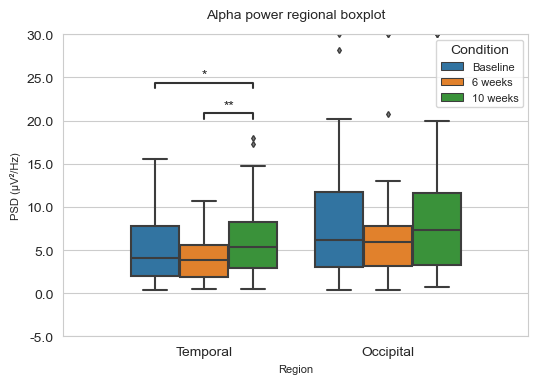

In [3]:
plot_boxplot_band(df_psd_reg,regions=['Temporal','Occipital'],band='Alpha',
                      condition_comp_list=condition_codes_comparisons,
                      condition_legend=condition_legend,fnt=['sans-serif',8,10],
                      title=True,stat_test=stat_test,ast_loc='inside',yaxlims=[-5,30],yflierlims=[-5,30],
                      verbose=False,export=False)

In [ ]:
plot_boxplot_location(df_psd_reg,bands=['Delta','Theta','Alpha'],region='T8',
                      condition_comp_list=condition_codes_comparisons,
                      condition_legend=condition_legend,fnt=['sans-serif',8,10],
                      title=True,stat_test=stat_test,ast_loc='inside',verbose=False,export=False)


In [ ]:
for b_name in (df_psd_ch['Frequency band'].unique()):
    plot_boxplot_band(df_psd_reg,regions=['Frontal','Temporal','Centro-parietal','Occipital'],band=b_name,
                      condition_comp_list=condition_codes_comparisons,
                      condition_legend=condition_legend,fnt=['sans-serif',8,10],
                      title=True,stat_test=stat_test,ast_loc='inside',verbose=False,export=True)
    plot_topomaps_band(df_psd_ch,epochs,b_name,condition_legend=condition_legend,
                       conditions=condition_codes,fnt=['sans-serif',9],title=True,export=True)

Examples of using boxplot function for a chosen location for different bands and band boxplots again.

In [ ]:
plot_boxplot_location(df_psd_ch,bands=['Delta','Theta','Alpha'],region='T8',
                      condition_comp_list=condition_codes_comparisons,
                      condition_legend=condition_legend,fnt=['sans-serif',8,10],
                      title=True,stat_test=stat_test,ast_loc='inside',verbose=False,export=False)

plot_boxplot_band(df_psd_ch,regions=['F8','F4','FC6','T8','C4'],band='Alpha',
                  condition_comp_list=condition_codes_comparisons,
                  condition_legend=condition_legend,fnt=['sans-serif',8,10],
                  title=True,stat_test='Wilcoxon',ast_loc='inside',verbose=False,export=False)

plot_boxplot_band(df_psd_ch,regions=['FC1','Pz'],band='Low-Beta',
                  condition_comp_list=condition_codes_comparisons,
                  condition_legend=condition_legend,fnt=['sans-serif',8,10],
                  title=True,stat_test='Wilcoxon',ast_loc='inside',verbose=True,export=False)
